In [1]:
import pickle
from pathlib import Path

import lmdb
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import seaborn as sns
import umap
from sklearn.preprocessing import StandardScaler


# Visualizing Embeddings from VQ-VAE-2 Using UMAP
 Representation learning to see how latent space interacts with known labels
 Author: Akshay Goel

## Import Embeddings in Lightning Memory-Mapped Database Manager (LMDB)
 Embeddings are combined with categorical labels. Current labels are based on pixels of a particular class for a given volume.

In [2]:
root = Path("/myfilestore/efs_backups/akshay/04_cropped_OHSU_GT_embeddings_1")

embeddings_dir = Path(
   "/myfilestore/efs_backups/akshay/04_cropped_OHSU_GT_embeddings_1/version_8_epoch=33588-step=7154455.lmdb"
)




In [3]:

embedding_paths = pd.read_csv (root / "data.csv")

mask_labels = pd.read_csv (root / "mask_data.csv")

# Isolates stems for mask and volumes to merge csv data
# TODO: Move outside of this script

SUFFIX_MASK = "__init" # adjust to isolate stem at [0]
mask_labels['key'] = mask_labels.apply(lambda x: x['filename'].split(SUFFIX_MASK)[0], axis=1) 
mask_labels.drop_duplicates('key', inplace=True)

SUFFIX_VOL = "__vol__cropped"
embedding_paths['key'] = embedding_paths.apply(lambda x: x['file_name'].split(SUFFIX_VOL)[0], axis=1) 

mask_data = pd.merge(embedding_paths, mask_labels, on='key', how='left')



## Read Data fro LMDB

In [4]:

def get_sample_at_idx(idx: int, txn: lmdb.Transaction, unpickle=True):
    sample = txn.get(str(idx).encode())

    if unpickle:
        sample = pickle.loads(sample)  # type: ignore

    return sample


lmdb_env = lmdb.open(
    str(embeddings_dir), readonly=True
)  # for async set lock=False

data = []


In [5]:
# Start a new read transaction
with lmdb_env.begin() as txn:

    # Encode the key the same way as we stored it

    length: int = int(txn.get(b"length"))  # type: ignore
    n_bottleneck_blocks: int = int(txn.get(b"n_bottleneck_blocks"))  # type: ignore

    print(f"dataset length {int(length)}")  # type: ignore
    print(f"n_bottleneck_blocks  {int(n_bottleneck_blocks)}")  # type: ignore
    print("\nFirst few examples:")
    for idx in range(length):
        sample: list = get_sample_at_idx(idx, txn)  # type: ignore
        
        if idx < 3:
            print(
                f"sample #{idx} : {[sample[neck_idx].shape for neck_idx in range(n_bottleneck_blocks)]}"
            )
            
        data.append(sample)

    print("...\n... all embeddings added from disk")

lmdb_env.close()


dataset length 152
n_bottleneck_blocks  3

First few examples:
sample #0 : [(1, 32, 32, 32), (1, 8, 8, 8), (1, 2, 2, 2)]
sample #1 : [(1, 32, 32, 32), (1, 8, 8, 8), (1, 2, 2, 2)]
sample #2 : [(1, 32, 32, 32), (1, 8, 8, 8), (1, 2, 2, 2)]
...
... all embeddings added from disk


In [6]:

assert len(data) == len(mask_data), "Embeddings and mask_data must be 1 to 1"

## Flatten Data to combine Bottle Necks in VQ-VAE-2 into Three Columns

In [7]:
flattened_data = [
    np.asarray([d[bottle_neck_idx].flatten() for d in data], dtype=np.float64)
    for bottle_neck_idx in range(3)
]


## Scale Data for Each Bottle Neck Column

In [8]:

scaled_data = [
    StandardScaler().fit_transform(flattened_data[bottle_neck_idx])
    for bottle_neck_idx in range(3)
]


## Color Scale for Upcoming Plots
 Note: Only first 3 colors are relevant

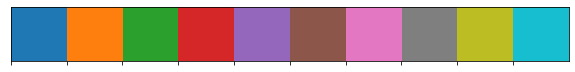

In [9]:
current_palette = sns.color_palette()
sns.palplot(current_palette)

plt.savefig(f"Color Scale")
plt.show()

## Produce UMAP for Each Category and Each Bottle Neck
 Total plots = Number_Categories x Bottle Necks
 Plots are saved as PNG files

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


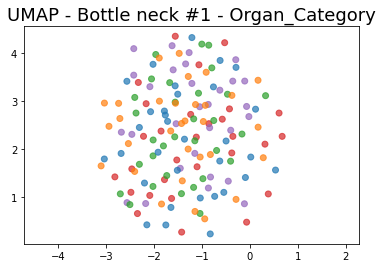

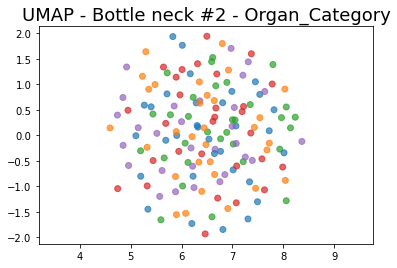

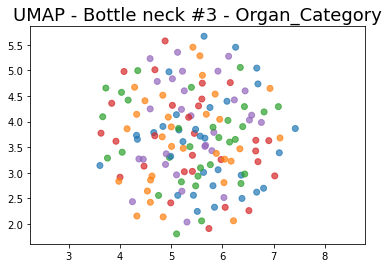

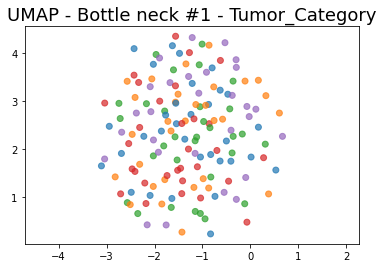

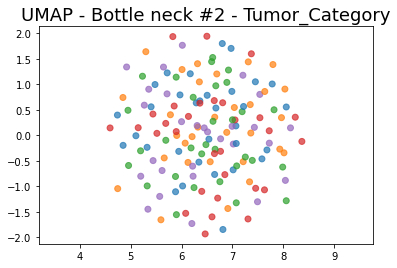

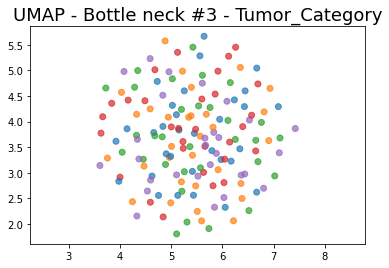

In [10]:
categories = ["Organ_Category", "Tumor_Category"]

for category in categories:
    for bottle_neck_idx in range(3):

        reducer = umap.UMAP(random_state=22, transform_seed=22)
        embedding = reducer.fit_transform(scaled_data[bottle_neck_idx])
        
        color_source = mask_data[category].to_numpy()
        
        f, ax = plt.subplots(1, 1)
        
        scatter = ax.scatter(
            embedding[:, 0],
            embedding[:, 1],
            c=[sns.color_palette()[x] for x in color_source],
            alpha=0.7
        )
        plt.gca().set_aspect("equal", "datalim")
        plt.title(
            f"UMAP - Bottle neck #{bottle_neck_idx+1} - {category}",
            fontsize=18,
        )
        
        plt.show()
        f.savefig(f"{category}_bn={bottle_neck_idx}.png", dpi=300)


# Exploring Variation of Embeddings: Real vs. Random

## Real Categories

In [11]:
uniques, frequency = np.unique(mask_data["Tumor_Category"], return_counts=True)
print(f"Counts of different categories: {frequency}")

Counts of different categories: [32 31 31 30 28]


In [12]:

for bottle_neck_idx in range(3):
    embedding = reducer.fit_transform(scaled_data[bottle_neck_idx])
    print(f"---bottle neck: {bottle_neck_idx} ---")
    for category_idx in uniques:
        categories = mask_data["Tumor_Category"].to_numpy()
        embedding_w_mask = np.column_stack((embedding, categories))
        selection = embedding_w_mask[:,2] == category_idx
        
        embeddings_subset = embedding_w_mask[selection]
        var = np.var(embeddings_subset, axis=0)
        print(f"Var for {category_idx} is {var} for bottle-neck {bottle_neck_idx}")


---bottle neck: 0 ---
Var for 0 is [0.78264895 0.95886043 0.        ] for bottle-neck 0
Var for 1 is [0.82250703 1.02752469 0.        ] for bottle-neck 0
Var for 2 is [0.61279525 1.04111557 0.        ] for bottle-neck 0
Var for 3 is [0.62121024 1.02068566 0.        ] for bottle-neck 0
Var for 4 is [0.90682009 1.13503208 0.        ] for bottle-neck 0
---bottle neck: 1 ---
Var for 0 is [0.71700767 0.688668   0.        ] for bottle-neck 1
Var for 1 is [0.82208757 0.73175135 0.        ] for bottle-neck 1
Var for 2 is [0.67915792 0.75573438 0.        ] for bottle-neck 1
Var for 3 is [0.76160477 0.98130772 0.        ] for bottle-neck 1
Var for 4 is [0.83154522 0.79428866 0.        ] for bottle-neck 1
---bottle neck: 2 ---
Var for 0 is [0.64393698 0.70378788 0.        ] for bottle-neck 2
Var for 1 is [0.65723743 0.86037248 0.        ] for bottle-neck 2
Var for 2 is [0.79206182 0.85928662 0.        ] for bottle-neck 2
Var for 3 is [0.79195019 0.7267448  0.        ] for bottle-neck 2
Var for 4 

## Random Categories

In [13]:
from random import randint

rand_categories = [randint(0, 2) for _ in range(len(embedding))]
rand_categories = np.asarray(rand_categories)
uniques, frequency = np.unique(rand_categories, return_counts=True)
print(f"Counts of random categories: {frequency}")

for bottle_neck_idx in range(3):
    embedding = reducer.fit_transform(scaled_data[bottle_neck_idx])
    print(f"---bottle neck: {bottle_neck_idx} ---")
    for category in uniques:
        embedding_w_mask = np.column_stack((embedding, rand_categories))
        selection = embedding_w_mask[:,2] == category
        
        embeddings_subset = embedding_w_mask[selection]
        var = np.var(embeddings_subset, axis=0)
        print(f"Var (random) for {category} is {var}")


Counts of random categories: [43 55 54]
---bottle neck: 0 ---
Var (random) for 0 is [0.55088999 1.03398501 0.        ]
Var (random) for 1 is [1.03463215 0.90042997 0.        ]
Var (random) for 2 is [0.64731238 1.23807213 0.        ]
---bottle neck: 1 ---
Var (random) for 0 is [0.59700026 0.85980363 0.        ]
Var (random) for 1 is [1.02714244 0.78779901 0.        ]
Var (random) for 2 is [0.63309837 0.70185025 0.        ]
---bottle neck: 2 ---
Var (random) for 0 is [0.76453889 0.64828411 0.        ]
Var (random) for 1 is [0.89490283 0.90429775 0.        ]
Var (random) for 2 is [0.60280767 0.76977317 0.        ]
